### What is ChromBPNet?
Author: Jacob Schreiber \<jmschreiber91@gmail.com\>

#### Introduction

ChromBPNet is a deep learning model that uses DNA sequence to predict chromatin accessibility readouts, usually from ATAC-seq or DNase-seq experiments. Unlike other predictive models of chromatin accessibility, ChroBPNet explicitly models the sequence-specific enzyme bias which can confound the precise positioning of reads in the experimental readouts. This correction can be particularly important to do when the models, like Chrom/BPNet, make predictions at basepair resolution, because the experimental readout (and subsequent predictions) will be much noisier than one might expect.

The architecture of a ChromBPNet model is simply a pair of BPNet models "holding hands." One of these models is trained to predict the enzymatic bias from sequence alone, and the other model is subsequently trained to predict the residual between these bias predictions and the experimental predictions, i.e., the true accessibility signal. Both models are usually variants of BPNet models, with the bias model usually having more filters than the standard BPNet model (128 seems to be common) but fewer layers (4 layers is also common) because the bias is a very local phenomena, and the accessibility model having many more filters than a standard BPNet model (256 or 512) and the same number of layers. The profile predictions from the two models are added together in logit space, representing a multiplication in probability space, and the count predictions are logsumexp'd, representing an addition in count space. 

Briefly, ChromBPNet models are trained by first training the bias model on GC-matched non-peak regions in the genome, where reads are still present by chance but their positioning is still dictated by this bias. Once the bias model has been confirmed to have captured the bias and no other motifs, it is frozen and incorporated into the full ChromBPNet model. In tandem with this frozen bias model, the accessibility model is then trained to predict accessibility signal at peaks and GC-matched non-peak regions, following a similar protocol to a standard BPNet model. 

<img src="img/chrombpnet-schematic.png">

At a high level, one can think of the accessibility model at the end of the ChromBPNet training procedure in the same manner that one thinks of a BPNet model, except that the output is accessibility instead of transcription factor binding. This means that the considerations about the model being trained on only one cell type are the same for BPNet and ChromBPNet models, with downsides being that accuracy may be slightly worse when compared with massively multi-task models, but the ChromBPNet models are less prone to overfitting to statistical artifacts that other models can pick up on, simply by virtue of only seeing experimental readouts in one cell type.

#### Using ChromBPNet

##### Loading Models from the ENCODE Portal

In the BPNet introduction, we saw how one can load a PyTorch model that is saved on disk pretty easily. Here, we will consider the more complex situation where not only does one want to load a ChromBPNet model that has been trained using the official <i>TensorFlow</i> implementation, but one wants to load a model that has been uploaded to the ENCODE Portal. Loading models from the ENCODE Portal is even more challenging because, in addition to having to convert from TensorFlow to PyTorch, one has to pull out the model of interest from a set of ChromBPNet models for each of five folds that are packaged together. Fortunately, loading models directly from `.tar.gz` files is actually quite simple without needing to extract and unpack the file if you have the right tools. Thanks to Christian Ramirez for showing me this neat trick.

First, we need to download a tar file from the ENCODE Portal. Here is an example of a set of five ChromBPNet models trained to make predictions for DNase-seq in K562. https://www.encodeproject.org/files/ENCFF574YLK/

All we have to do is open it using `tarfile`, pull out the specific model files using `tar.extractfile(...).read()`, and then use `BytesIO` to turn that stream into something that can be natively read by bpnet-lite.

In [1]:
import tarfile

from io import BytesIO
from bpnetlite.chrombpnet import ChromBPNet

with tarfile.open("ENCFF574YLK.tar.gz", "r:gz") as tar:
    bias_tar = tar.extractfile("./fold_0/model.bias_scaled.fold_0.ENCSR000EOT.h5").read()
    accessibility_tar = tar.extractfile("./fold_0/model.chrombpnet_nobias.fold_0.ENCSR000EOT.h5").read()

chrombpnet = ChromBPNet.from_chrombpnet(
    BytesIO(bias_tar),
    BytesIO(accessibility_tar)
)

chrombpnet

ChromBPNet(
  (bias): BPNet(
    (iconv): Conv1d(4, 128, kernel_size=(21,), stride=(1,), padding=(10,))
    (irelu): ReLU()
    (rconvs): ModuleList(
      (0): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(2,), dilation=(2,))
      (1): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(4,), dilation=(4,))
      (2): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(8,), dilation=(8,))
      (3): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(16,), dilation=(16,))
    )
    (rrelus): ModuleList(
      (0-3): 4 x ReLU()
    )
    (fconv): Conv1d(128, 1, kernel_size=(75,), stride=(1,), padding=(37,))
    (linear): Linear(in_features=128, out_features=1, bias=True)
  )
  (accessibility): BPNet(
    (iconv): Conv1d(4, 512, kernel_size=(21,), stride=(1,), padding=(10,))
    (irelu): ReLU()
    (rconvs): ModuleList(
      (0): Conv1d(512, 512, kernel_size=(3,), stride=(1,), padding=(2,), dilation=(2,))
      (1): Conv1d(512, 512, kernel_size=(3,), stride=(1

In just a few lines of code we were able to pull out only the model files we cared about from this tar, decompress and read them, and then load that into a PyTorch model. This Pytorch model makes exactly the same predictions as the original TensorFlow one and is compatible with all of the other tools we have been using, e.g., tangermeme. See our later notebook demonstrating that the predictions are identical if you are interested in the details.

If we take a look at the summary of the ChromBPNet model we see that the two main components are the bias model and the accessibility model, both of which are BPNet objects. These can be accessed individually. If you want to pull out the accessibility model you can just do the following.

In [2]:
chrombpnet.accessibility

BPNet(
  (iconv): Conv1d(4, 512, kernel_size=(21,), stride=(1,), padding=(10,))
  (irelu): ReLU()
  (rconvs): ModuleList(
    (0): Conv1d(512, 512, kernel_size=(3,), stride=(1,), padding=(2,), dilation=(2,))
    (1): Conv1d(512, 512, kernel_size=(3,), stride=(1,), padding=(4,), dilation=(4,))
    (2): Conv1d(512, 512, kernel_size=(3,), stride=(1,), padding=(8,), dilation=(8,))
    (3): Conv1d(512, 512, kernel_size=(3,), stride=(1,), padding=(16,), dilation=(16,))
    (4): Conv1d(512, 512, kernel_size=(3,), stride=(1,), padding=(32,), dilation=(32,))
    (5): Conv1d(512, 512, kernel_size=(3,), stride=(1,), padding=(64,), dilation=(64,))
    (6): Conv1d(512, 512, kernel_size=(3,), stride=(1,), padding=(128,), dilation=(128,))
    (7): Conv1d(512, 512, kernel_size=(3,), stride=(1,), padding=(256,), dilation=(256,))
  )
  (rrelus): ModuleList(
    (0-7): 8 x ReLU()
  )
  (fconv): Conv1d(512, 1, kernel_size=(75,), stride=(1,), padding=(37,))
  (linear): Linear(in_features=512, out_features=

Note that this is a complete PyTorch model that can be used by itself without needing to be a part of the larger ChromBPNet model.

Likewise, if we want to pull out just the bias model:

In [3]:
chrombpnet.bias

BPNet(
  (iconv): Conv1d(4, 128, kernel_size=(21,), stride=(1,), padding=(10,))
  (irelu): ReLU()
  (rconvs): ModuleList(
    (0): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(2,), dilation=(2,))
    (1): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(4,), dilation=(4,))
    (2): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(8,), dilation=(8,))
    (3): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(16,), dilation=(16,))
  )
  (rrelus): ModuleList(
    (0-3): 4 x ReLU()
  )
  (fconv): Conv1d(128, 1, kernel_size=(75,), stride=(1,), padding=(37,))
  (linear): Linear(in_features=128, out_features=1, bias=True)
)

This means that if we want to make predictions or do model operations with both the bias and the accessibility model, we can use the ChromBPNet model in its entirety.

##### Predicting Accessibility and Bias

Regardless of the approach we take to loading ChromBPNet models (from .torch files, from TensorFlow .h5s, from a set of models tarred together like above...), our next step is usually to predict the accessibility of sequences. Let's load up some accessibility peaks directly from the corresponding peak file and try it out.

In [4]:
from tangermeme.io import extract_loci
from tangermeme.predict import predict

X = extract_loci(
    "https://www.encodeproject.org/files/ENCFF185XRG/@@download/ENCFF185XRG.bed.gz", 
    "../../../../common/hg38.fa",
    n_loci=150,
    verbose=True)

y_profile, y_counts = predict(chrombpnet, X)
y_profile.shape, y_counts.shape

Loading Loci:   0%|                                                             | 149/159277 [00:00<00:02, 57509.09it/s]


(torch.Size([150, 1, 1000]), torch.Size([150, 1]))

Similarly to before, ChromBPNet models make predictions for profiles at basepair resolution and for log counts as a single scalar per eample. Because accessibility is not really a stranded phenomena, these predictions are not made on a stranded basis. But perhaps a more important difference is that there are three ways to make predictions from a ChromBPNet model: (1) from the full model to match experimental readouts, (2) from the bias model to capture the sequence specificity of the cutting enzyme, and (3) from the accessibility model, to predict the true accessibility after factorizing out the bias. With these models, we can take a look at all three.

As a technical note, the bias model only has four layers in it, which means that fewer positions are trimmed off the edges than a model with 8 layers. The ChromBPNet model object handles this trimming for you, but if you use the bias model by itself you may need to trim the outputs yourself.

In [19]:
import torch

y = predict(chrombpnet, X)[0]
y_bias = predict(chrombpnet.bias, X)[0]
y_bias = y_bias[:, :, y_bias.shape[-1]//2-500:y_bias.shape[-1]//2+500]
y_acc = predict(chrombpnet.accessibility, X)[0]

y_softmax = torch.softmax(y, dim=-1)
y_bias_softmax = torch.softmax(y_bias, dim=-1)
y_acc_softmax = torch.softmax(y_acc, dim=-1)

For demonstration, we are only going to look at the predicted profiles from all three models. This is because the bias usually significantly influences the profiles as the sequence specificiy changes *where* the cuts happen but it does not really change *how many* cuts happen, particularly when compared with other transcription factor binding events that make regions very accessible.

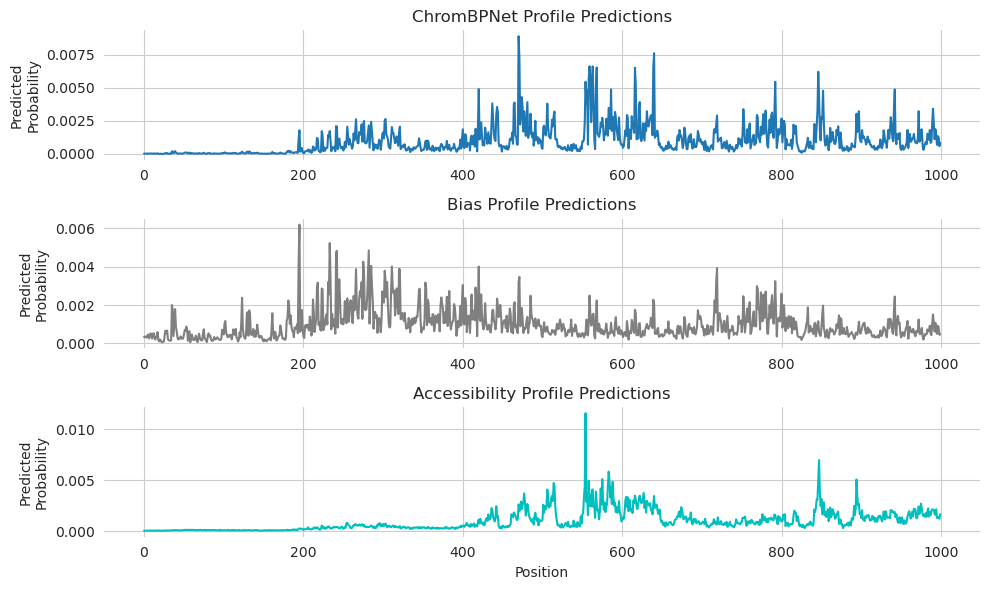

In [26]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn; seaborn.set_style('whitegrid')

idx = 60

plt.figure(figsize=(10, 6))

plt.subplot(311)
plt.title("ChromBPNet Profile Predictions")
plt.plot(y_softmax[idx, 0])
seaborn.despine(bottom=True, left=True)
plt.ylabel("Predicted\nProbability")

plt.subplot(312)
plt.title("Bias Profile Predictions")
plt.plot(y_bias_softmax[idx, 0], c='0.5')
seaborn.despine(bottom=True, left=True)
plt.ylabel("Predicted\nProbability")

plt.subplot(313)
plt.title("Accessibility Profile Predictions")
plt.plot(y_acc_softmax[idx, 0], c='c')
seaborn.despine(bottom=True, left=True)
plt.ylabel("Predicted\nProbability")
plt.xlabel("Position")

plt.tight_layout()
plt.show()

At the top, we can see a region that the full ChromBPNet model is predicting is accessible. It seems to have many little peaks and valleys that potentially could be footprints and accessibility peaks, but there is also a lot of noise so it's hard to know exactly what is going on. In the middle, we can see the bias model predictions which, interestingly, seem to line up with many of the predicted peaks in the full model. Finally, at the bottom, we have predictions from the accessibility model. These seem significantly cleaner than the predictions from the full model, with a whole span of waes between 200-300bp seem to completely disappear. The valleys in the predictions seem much cleaner, with fewer sikes within them.

Overall, the above example shows how ChromBPNet can be used to de-noise accessible regions. In this situation, the region is clearly accessible and the models are predicting that it is accessible but the signal is much sharper once the noise has been removed.

Let's now consider another situation...

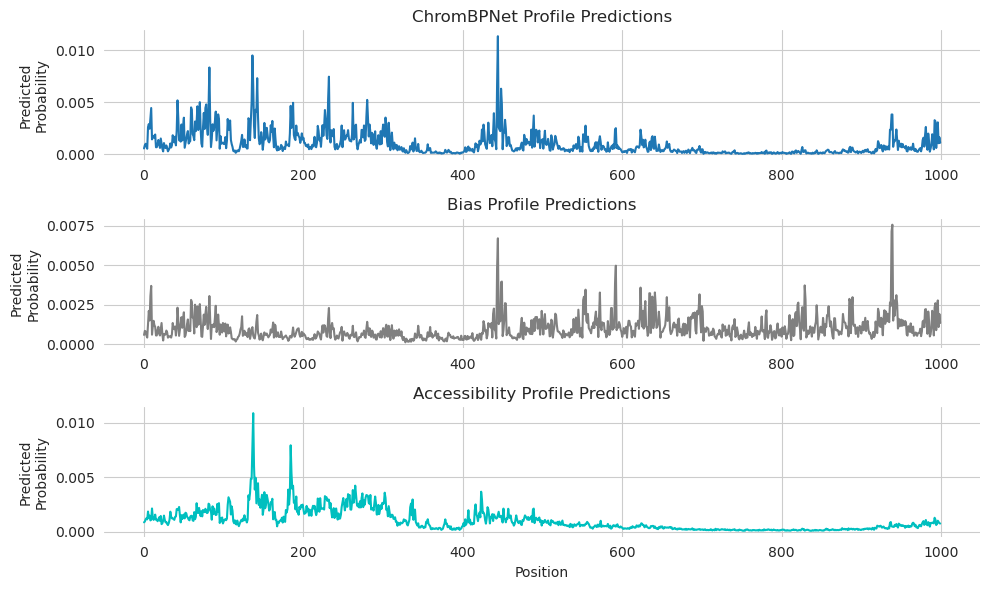

In [27]:
idx = 61

plt.figure(figsize=(10, 6))

plt.subplot(311)
plt.title("ChromBPNet Profile Predictions")
plt.plot(y_softmax[idx, 0])
seaborn.despine(bottom=True, left=True)
plt.ylabel("Predicted\nProbability")

plt.subplot(312)
plt.title("Bias Profile Predictions")
plt.plot(y_bias_softmax[idx, 0], c='0.5')
seaborn.despine(bottom=True, left=True)
plt.ylabel("Predicted\nProbability")

plt.subplot(313)
plt.title("Accessibility Profile Predictions")
plt.plot(y_acc_softmax[idx, 0], c='c')
seaborn.despine(bottom=True, left=True)
plt.ylabel("Predicted\nProbability")
plt.xlabel("Position")

plt.tight_layout()
plt.show()

In this example, the ChromBPNet model is predicting a spike in the middle that one might interpret to be the primary feature and the most accessible part of the region. However, when we look at preidctions from the bias model we see a peak at exactly the same coordinates. When we consider the accessibility model predictions, we see that this peak has completely disappeared: it was entirely an artifact of the sequence bias. Although there are still other peak-like shapes which are driving accessibility, this example demonstrates that modeling the bias explicitly is important because even the most prominent features are not necessarily always real.

##### Attributions

Perhaps more common than making predictions using ChromBPNet models is considering their attributions. When using methods like DeepLIFT/SHAP or in silico saturation mutagenesis, one can identify the nucleotides that are driving predicted accessibility. Like with the BPNet models, we need to wrap the model in a `CountWrapper` or a `ProfileWrapper` so that we are applying our feature attribution method to a single scalar value. In most settings, we care most about the accessibility model and so we will wrap that by itself

In [9]:
from bpnetlite.bpnet import CountWrapper

counts_model = CountWrapper(chrombpnet.accessibility)

predict(counts_model, X[idx:idx+1])

tensor([[7.0405]])

Similar to how we made predictions using all three models, we can calculate attributions using all three of them and compare.

In [30]:
from bpnetlite.bpnet import ProfileWrapper
from bpnetlite.attribute import deep_lift_shap
X_attr0 = deep_lift_shap(ProfileWrapper(chrombpnet), X[idx:idx+1])
X_attr1 = deep_lift_shap(ProfileWrapper(chrombpnet.bias), X[idx:idx+1])
X_attr2 = deep_lift_shap(ProfileWrapper(chrombpnet.accessibility), X[idx:idx+1])

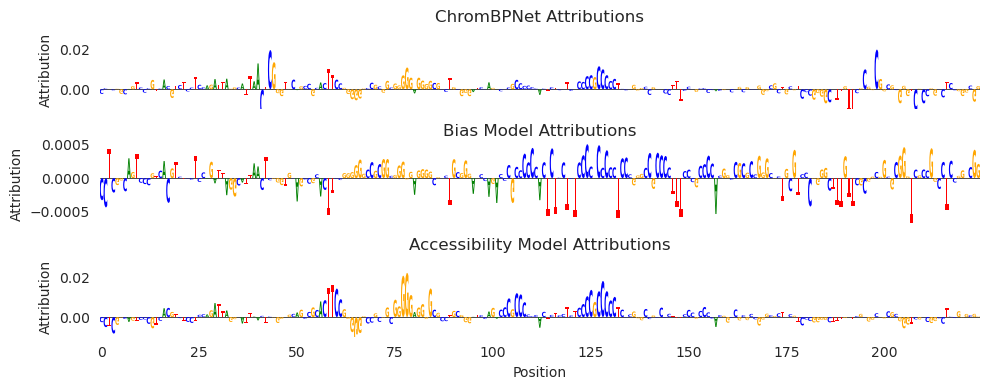

In [33]:
from tangermeme.plot import plot_logo

s, e = 600, 825

plt.figure(figsize=(10, 4))
plt.subplot(311)
plt.title("ChromBPNet Attributions")
plot_logo(X_attr0[0, :, s:e])
plt.grid(False)
plt.ylim(-0.01, 0.03)
plt.xticks([], [])
plt.ylabel("Attribution")

plt.subplot(312)
plt.title("Bias Model Attributions")
plot_logo(X_attr1[0, :, s:e])
plt.grid(False)
plt.xticks([], [])
plt.ylabel("Attribution")

plt.subplot(313)
plt.title("Accessibility Model Attributions")
plot_logo(X_attr2[0, :, s:e])
plt.grid(False)
plt.ylim(-0.01, 0.03)
plt.xlabel("Position")
plt.ylabel("Attribution")

plt.tight_layout()
plt.show()

It seems like there are some motif-like things in the attributions from the original ChromBPNet model but that, just like the predictions, there is a lot of noise. The attributions from the bias model seem to be almost entirely noise. But when we look at the attributions for the accessibility model alone, we see clean motifs. Some motif-like instances from the original ChromBPNet attributions are gone in the accessibility attributions, suggesting that it is not sufficient to just take anything resembling a motif from the ChromBPNet attributions even if it's noisy.

##### Variant Effect Prediction

In the same way that one can predict variant effect using BPNet models by comparing model predictions before and after including one or more substitutions, the exact same procedure can be done using a ChromBPNet model. In this setting, instead of returning a score that is based on predicted transcription factor binding, what is returned is the influence of the variant on chromatin accessibility, which is a much broader modality. To be clear, a difference in chromatin accessibility may not be the cause of the higher-order phenotype one may be studying, and a lack of a difference in chromatin accessibility may not mean that a region is unconnected to the phenotype, but it is a useful proxy.

Sometimes, there is a thought that individual mutations do not have strong effects by themselves. Here, we will take a look at what one mutation can have on predicted accessibility.

In [34]:
from tangermeme.variant_effect import substitution_effect

variants = [
    [0, 640, 3]
]

before, after = substitution_effect(chrombpnet.accessibility, X[:1], variants)
before = torch.softmax(before[0], dim=-1)
after = torch.softmax(after[0], dim=-1)

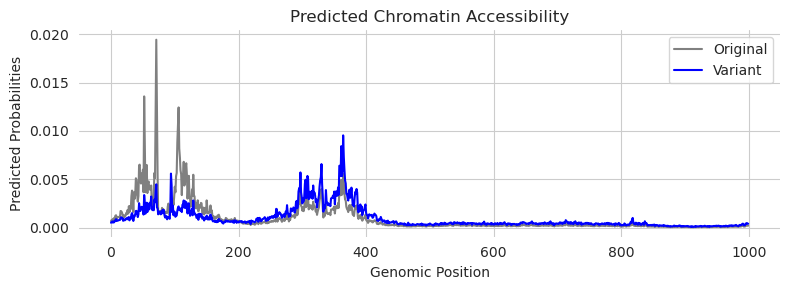

In [35]:
plt.figure(figsize=(8, 3))

plt.plot(before[0, 0], c='0.5', label="Original")
plt.plot(after[0, 0], c='b', label="Variant")

plt.title("Predicted Chromatin Accessibility")
plt.xlabel("Genomic Position")
plt.ylabel("Predicted Probabilities")

seaborn.despine(bottom=True, left=True)
plt.legend()

plt.tight_layout()
plt.show()

This single mutation seems to be knocking out an entire accessible peak while keeping the second peak basically the same.

##### Designing Differentially Accessible Regions

A recently popular thing to do with models that predict chromatin accessibility is to use them to design regions that exhibit differential patterns of accessible chromatin. This can be done somewhat easily with multi-task models by setting the desired predictions for one of the cell types to be high, and the desired predictions for the other cell types to be low. However, because ChromBPNet only makes predictions for a single cell type, you need to wrap several models together such that each take the same sequence and ultimately yield predictions in several cell types.

As an example of such design, we will use the Ledidi package because it has a wrapping tool built-in and because the Ledidi design method is quite fast compared to other approaches.

First, we will load up a second ChromBPNet model. This one will be trained to predict accessibility in GM12878 cells. We only want the accessibility portion so we can load that directly from the file.

In [14]:
from bpnetlite import BPNet

with tarfile.open("ENCFF142IOR.tar.gz", "r:gz") as tar:    
    accessibility_tar = tar.extractfile("./fold_0/model.chrombpnet_nobias.fold_0.ENCSR637XSC.h5").read()

gm_accessibility = BPNet.from_chrombpnet(BytesIO(accessibility_tar))

Next, we will load up a wrapper from Ledidi that allows us to pass in any number of models and will concatenate their predictions together. Naturally, this only works when the outputs are of the same shape. Here, we will use only the accessibility models from the two ChromBPNet models and use `CountWrapper` to extract only the count output from them.

In [15]:
from ledidi.wrappers import DesignWrapper

designer = DesignWrapper([
    CountWrapper(chrombpnet.accessibility.cuda()),
    CountWrapper(gm_accessibility.cuda())
])

We can then use this wrapper just like a multi-task model, including making predictions on a sequence using tangermeme just like normal.

In [16]:
predict(designer, X[:1])

tensor([[5.7403, 6.5372]])

Now we can use the Ledidi design algorithm to edit the sequence in a manner that achieves some desired output predictions. As a toy example, we will try to diminish accessibility in our first cell type and increase accessibility in the second cell type.

In [17]:
from ledidi import ledidi

y_bar = torch.tensor([[4.0, 9.0]])
X_bar = ledidi(designer, X[:1].float(), y_bar, verbose=True)

iter=I	input_loss=0.0	output_loss=4.547	total_loss=4.547	time=0.0
iter=100	input_loss=21.62	output_loss=0.1685	total_loss=2.331	time=4.193
iter=200	input_loss=28.25	output_loss=0.1085	total_loss=2.934	time=3.051
iter=300	input_loss=25.62	output_loss=0.07308	total_loss=2.636	time=3.051
iter=F	input_loss=17.56	output_loss=0.1925	total_loss=1.949	time=12.62


Looks like we made only a few edits to our 2,114bp input sequence and were able to bring the output loss down. What do the predictions look like for a batch of edited sequences?

In [18]:
predict(designer, X_bar)

tensor([[4.1856, 8.5050],
        [4.3393, 8.5831],
        [4.0891, 8.4167],
        [4.3276, 8.4401],
        [4.3260, 8.5662],
        [4.4218, 8.6841],
        [4.2053, 8.2469],
        [4.2826, 8.6764],
        [4.3794, 8.5978],
        [4.2794, 8.9109],
        [4.5384, 8.6479],
        [4.4256, 8.7034],
        [4.4859, 8.4510],
        [4.2175, 8.1000],
        [4.2981, 8.4918],
        [4.2978, 8.2570]])

Looks pretty close to what we wanted the model to predict. Seems like we were able to turn this region, which is normally predicted to be accessible in both cell types, into a region that is much more accessible in one cell type than the other

#### Conclusion

ChromBPNet is a powerful model of chromatin accessibility that can explicitly factorize out the sequence-specific bias of the enzymes used in chromatin accessibility experiments. I think of ChromBPNet models as two BPNet models holding hands, with only modeling this underlying bias, and one modeling the true accessibility of the region. After training, one can discard the bias model and proceeds solely with the accessibility model for all subsequent analyses. Because the accessibility model is conceptually (and also explicitly implemented in bpnet-lite as) a BPNet model, one can essentially use this accessibility model to do all the things one might consider with a BPNet model: calculate attributions, make variant effect predictions, and perform design.